## Setup

In [1]:
import os
import json
import glob
import torch
import re
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
#import seaborn as sns
import matplotlib.pyplot as plt
from utils.data_processing import (
    load_edge_scores_into_dictionary,
    read_json_file,
    get_ckpts,
    load_metrics,
    compute_ged,
    compute_weighted_ged,
    compute_gtd,
    compute_jaccard_similarity_to_reference,
    compute_jaccard_similarity,
    aggregate_metrics_to_tensors_step_number,
    get_ckpts
)

In [2]:
# =============================================================================
import kaleido
pio.renderers.default = 'png' # USE IF MAKING GRAPHS FOR NOTEBOOK EXPORT
# =============================================================================

In [3]:
TASK = 'greater_than'
PERFORMANCE_METRIC = 'prob_diff'

## Retrieve & Process Data

### Circuit Data

In [ ]:
folder_path = f'results/graphs/pythia-160m/{TASK}'
df = load_edge_scores_into_dictionary(folder_path)

### Performance Data

In [5]:
directory_path = 'results'
perf_metrics = load_metrics(directory_path)

ckpts = get_ckpts(schedule="exp_plus_detail")
#pythia_evals = aggregate_metrics_to_tensors_step_number("results/pythia-evals/pythia-v1")

In [6]:
perf_metric = perf_metrics['pythia-160m'][TASK][PERFORMANCE_METRIC]

perf_metric = [x.item() for x in perf_metric]

# zip into dictionary with ckpts as key
perf_metric_dict = dict(zip(ckpts, perf_metric))


## Visualize Results

### Graph Size

In [7]:
# Summarize the total number of edges in the graph at each checkpoint, filtered by in_circuit
subgraph_df = df[df['in_circuit'] == True]

# Group by checkpoint and sum the number of edges
subgraph_df = subgraph_df.groupby('checkpoint').size().reset_index(name='num_edges')

subgraph_df.head()


,checkpoint,num_edges
0,2000,76
1,3000,112
2,4000,32
3,5000,34
4,6000,40


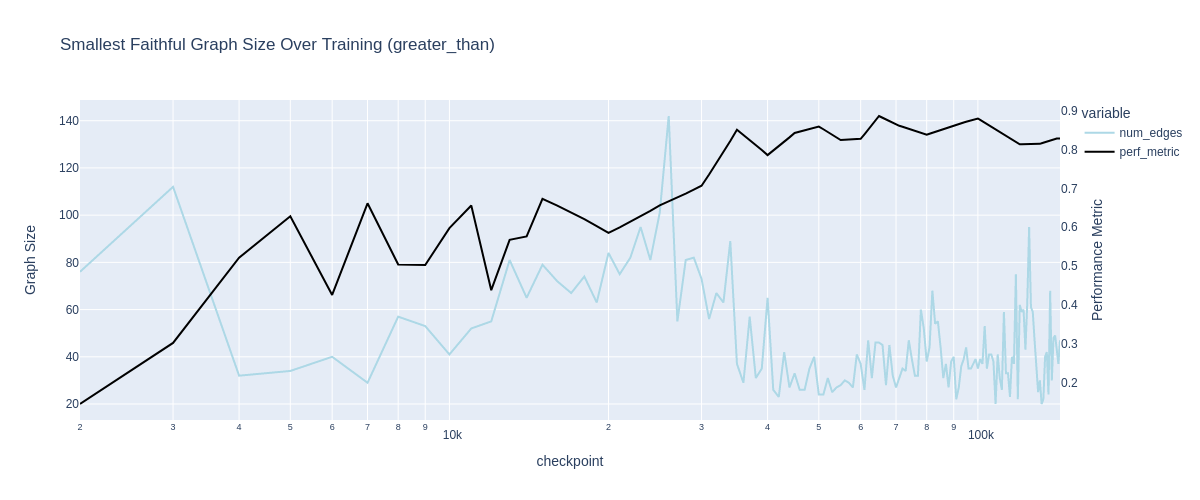

In [8]:
# Plot the number of edges in the subgraph at each checkpoint, along with performance metrics

# Add a new column for the performance metric by mapping the checkpoint values using the perf_metric_dict
subgraph_df['perf_metric'] = subgraph_df['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
subgraph_df['perf_metric'] = subgraph_df['perf_metric'].interpolate(method='linear')

# Plot the number of edges in the subgraph at each checkpoint
fig = px.line(subgraph_df, width=1200, x='checkpoint', y=['num_edges'], title=f'Smallest Faithful Graph Size Over Training ({TASK})', log_x=True)

# Specify colors for each line
colors = {'num_edges': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Performance Metric", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=subgraph_df['checkpoint'], y=subgraph_df['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Graph Size"
)

fig.show()


### Graph Transformations

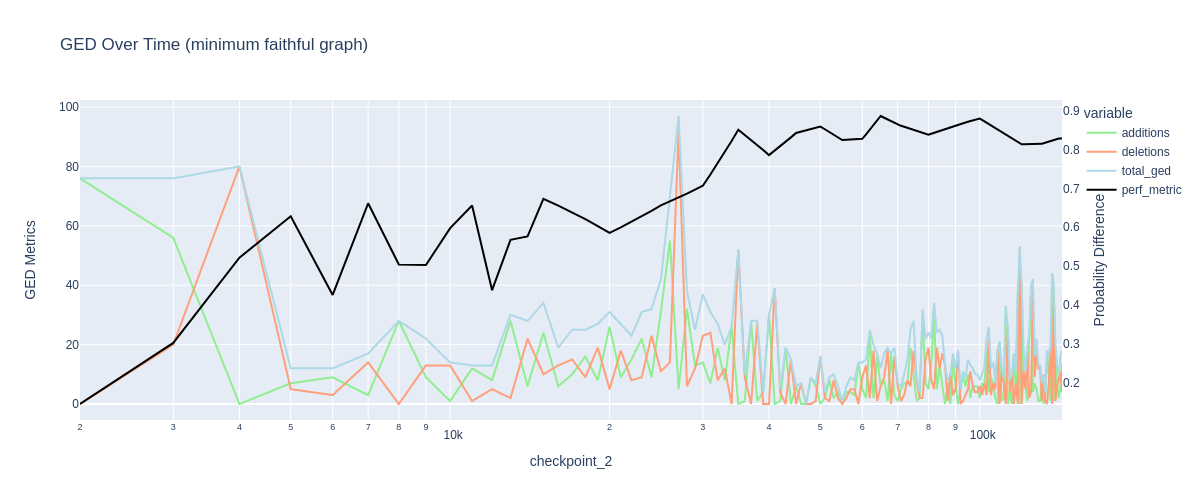

In [9]:
# Assuming ged_results is a DataFrame and compute_ged is a function that returns a DataFrame
ged_results = compute_ged(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
ged_results['perf_metric'] = ged_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
ged_results['perf_metric'] = ged_results['perf_metric'].interpolate(method='linear')

# Plotting as before
fig = px.line(ged_results, width=1200, x='checkpoint_2', y=['additions', 'deletions', 'total_ged'], title='GED Over Time (minimum faithful graph)', log_x=True)

# Specify colors for each line and update trace colors
colors = {'additions': 'lightgreen', 'deletions': 'lightsalmon', 'total_ged': 'lightblue', 'perf_metric': 'black'}
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))

# Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=ged_results['checkpoint_2'], y=ged_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout for titles or other aesthetics
fig.update_layout(yaxis_title="GED Metrics")
fig.show()

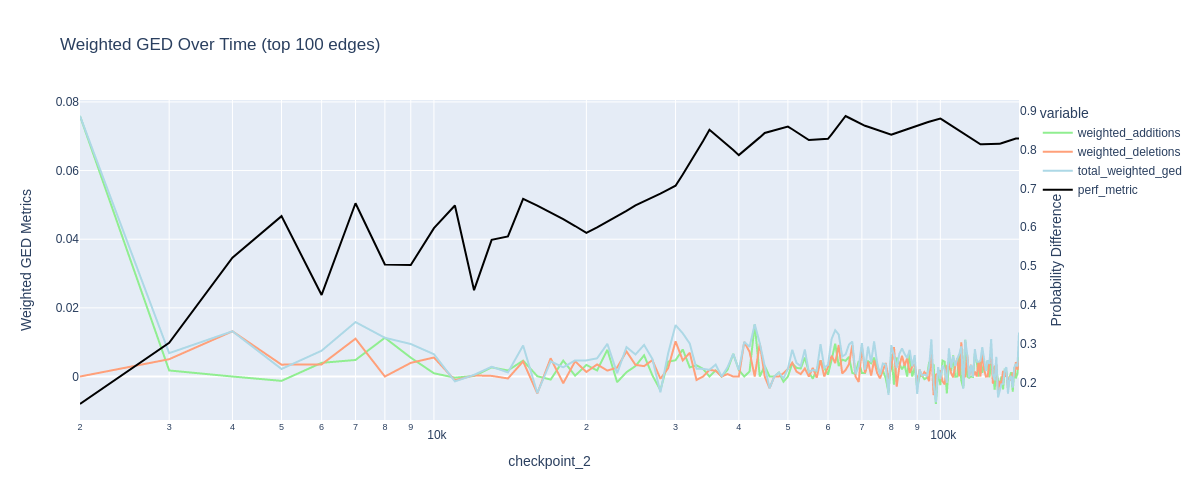

In [10]:
weighted_ged_results = compute_weighted_ged(df)
# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
weighted_ged_results['perf_metric'] = weighted_ged_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
weighted_ged_results['perf_metric'] = weighted_ged_results['perf_metric'].interpolate(method='linear')

# plot weighted additions, deletions, and total weighted GED over time
fig = px.line(weighted_ged_results, width=1200, x='checkpoint_2', y=['weighted_additions', 'weighted_deletions', 'total_weighted_ged'], title='Weighted GED Over Time (top 100 edges)', log_x=True)

# Specify colors for each line
colors = {'weighted_additions': 'lightgreen', 'weighted_deletions': 'lightsalmon', 'total_weighted_ged': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


# Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=weighted_ged_results['checkpoint_2'], y=weighted_ged_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Weighted GED Metrics"
)

fig.show()

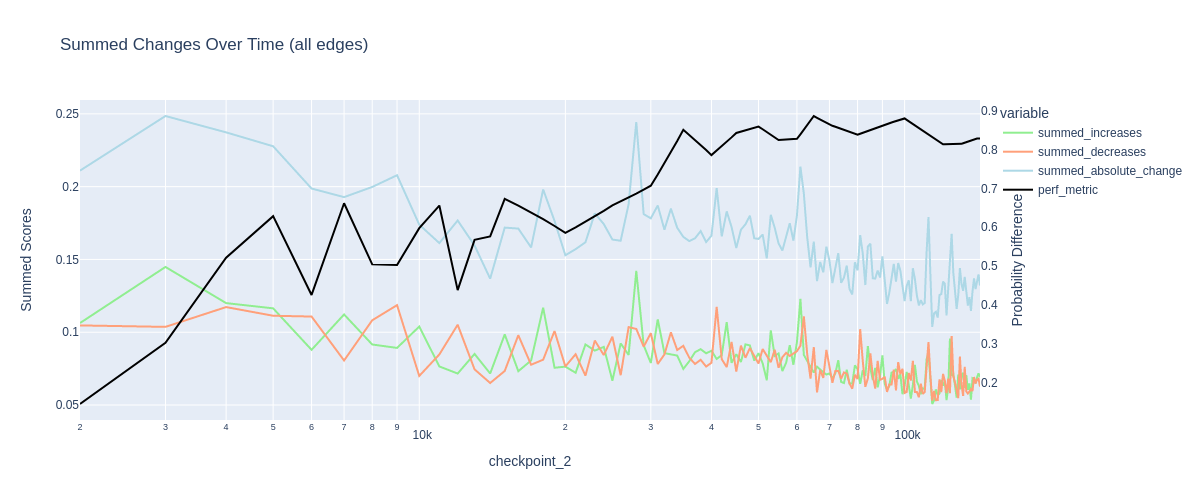

In [11]:
gtd_results = compute_gtd(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
gtd_results['perf_metric'] = gtd_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
gtd_results['perf_metric'] = gtd_results['perf_metric'].interpolate(method='linear')

# plot weighted additions, deletions, and total weighted GTD over time
fig = px.line(gtd_results, width=1200, x='checkpoint_2', y=['summed_increases', 'summed_decreases', 'summed_absolute_change'], title='Summed Changes Over Time (all edges)', log_x=True)

# Specify colors for each line
colors = {'summed_increases': 'lightgreen', 'summed_decreases': 'lightsalmon', 'summed_absolute_change': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


# Convert to a go.Figure to add secondary Y-axis features and add the performance metric line
fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=gtd_results['checkpoint_2'], y=gtd_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Summed Scores"
)

fig.show()

### Graph Similarity

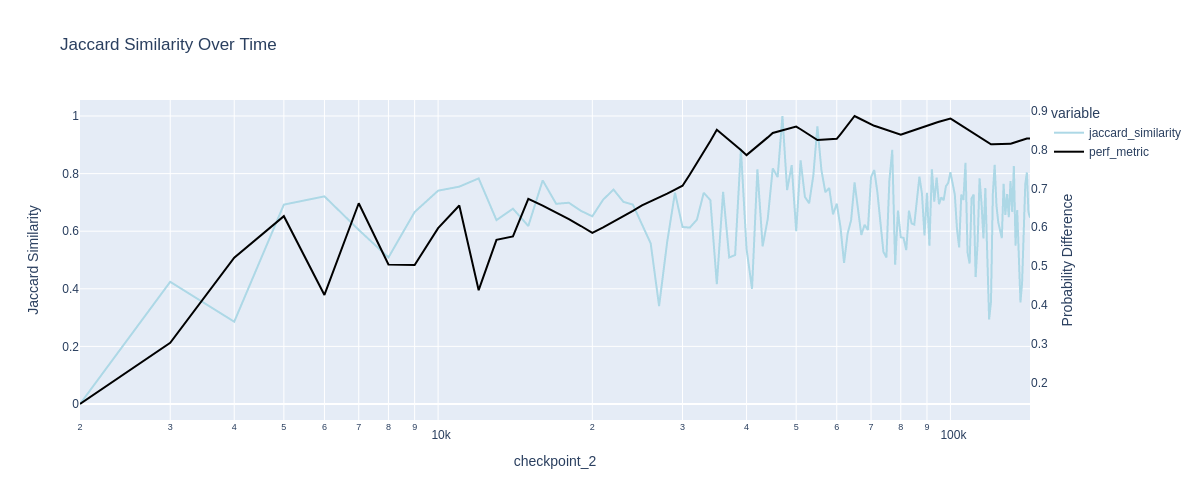

In [12]:
jaccard_results = compute_jaccard_similarity(df)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_results['perf_metric'] = jaccard_results['checkpoint_2'].map(perf_metric_dict)

# Interpolate missing values
jaccard_results['perf_metric'] = jaccard_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_results, width=1200, x='checkpoint_2', y=['jaccard_similarity'], title='Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_results['checkpoint_2'], y=jaccard_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title="Jaccard Similarity"
)

fig.show()

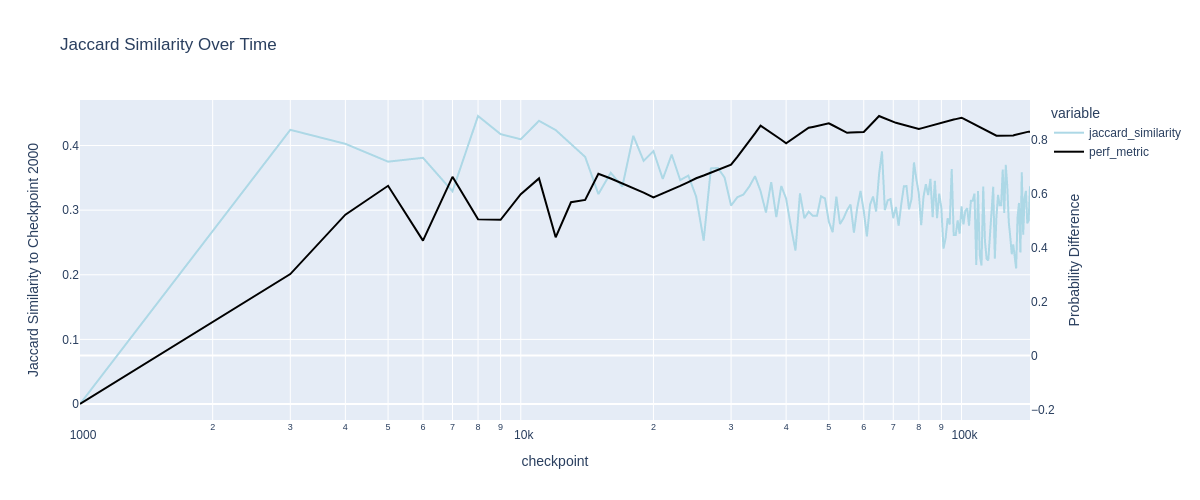

In [13]:
comparison_checkpoint = 2000

jaccard_reference_results = compute_jaccard_similarity_to_reference(df, comparison_checkpoint)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_reference_results['perf_metric'] = jaccard_reference_results['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
jaccard_reference_results['perf_metric'] = jaccard_reference_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_reference_results, width=1200, x='checkpoint', y=['jaccard_similarity'], title='Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_reference_results['checkpoint'], y=jaccard_reference_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title=f"Jaccard Similarity to Checkpoint {comparison_checkpoint}"
)

fig.show()

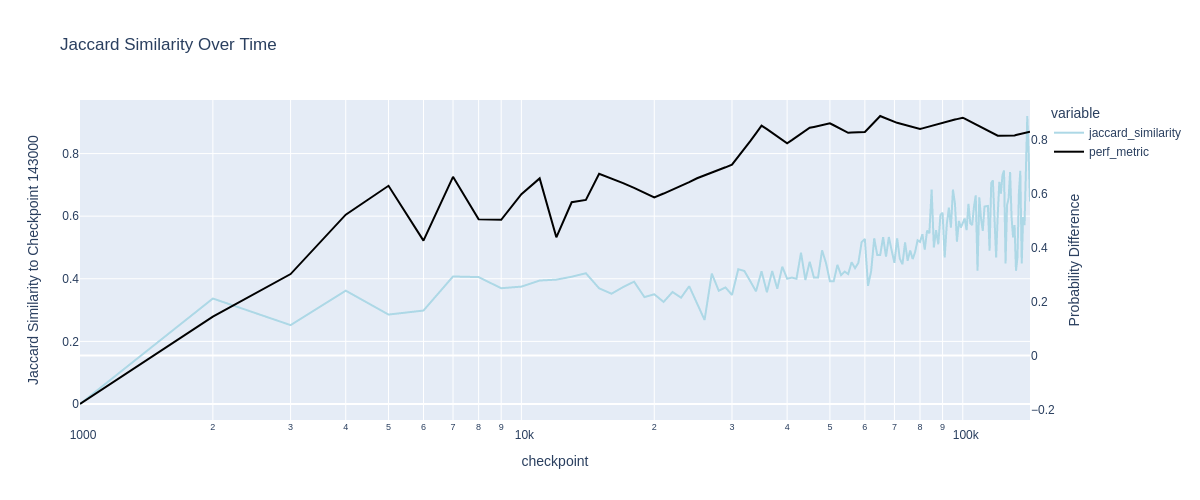

In [14]:
comparison_checkpoint = 143000

jaccard_reference_results = compute_jaccard_similarity_to_reference(df, comparison_checkpoint)

# Add a new column for the performance metric by mapping the checkpoint_2 values using the perf_metric_dict
jaccard_reference_results['perf_metric'] = jaccard_reference_results['checkpoint'].map(perf_metric_dict)

# Interpolate missing values
jaccard_reference_results['perf_metric'] = jaccard_reference_results['perf_metric'].interpolate(method='linear')

# plot jaccard similarity over time
fig = px.line(jaccard_reference_results, width=1200, x='checkpoint', y=['jaccard_similarity'], title='Jaccard Similarity Over Time', log_x=True)

# Specify colors for each line
colors = {'jaccard_similarity': 'lightblue', 'perf_metric': 'black'}

# Update each trace with the specified color
for i, trace in enumerate(fig.data):
    fig.data[i].update(line=dict(color=colors[trace.name]))


fig.update_layout(
    yaxis2=dict(title="Probability Difference", overlaying="y", side="right", showgrid=False)
)
fig.add_trace(
    go.Scatter(x=jaccard_reference_results['checkpoint'], y=jaccard_reference_results['perf_metric'], name='perf_metric', mode='lines', yaxis='y2', line=dict(color=colors['perf_metric']))
)

# Optional: Update the layout if you need to adjust titles or other aesthetics
fig.update_layout(
    yaxis_title=f"Jaccard Similarity to Checkpoint {comparison_checkpoint}"
)

fig.show()